# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [4]:
! pip install phik -q
! pip install catboost

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from scipy.stats import shapiro
import statistics
from sklearn.model_selection import train_test_split
import phik

from sklearn.metrics import mean_squared_error

from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from time import time
import phik
from sklearn.tree import DecisionTreeRegressor

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


import warnings
warnings.filterwarnings(action='ignore')



RANDOM_STATE = 42
TEST_SIZE = 0.2

In [6]:
def cat_num_col(df):
    num_col_names = list(df.select_dtypes(include=['int64', 'float64']).columns)
    cat_col_names = list(df.select_dtypes(include=['object']).columns)
    #cat_col_names.remove('id')
    return num_col_names, cat_col_names

In [7]:
def create_boxplot_and_histogram(data, column):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # График ящика с усами
    sns.boxplot(x=data[column], ax=axes[0])
    axes[0].set_title(f'Ящик с усами для {column}')
    axes[0].set_xlabel(column)

    # Гистограмма
    num_bins = int(np.ceil(np.sqrt(len(data[column]))))
    sns.histplot(data=data, x=column, kde=True, bins=num_bins, ax=axes[1])
    axes[1].set_title(f'{column} - Частота распределения', fontsize=18)
    axes[1].set_xlabel(column, fontsize=14)
    axes[1].set_ylabel('Частота', fontsize=14)

    plt.show()

In [8]:
#функция для модели
def train_models(df):
    X_train, X_valid, y_train, y_valid = train_test_split(
        df.drop(['product', 'id'], axis=1),
        df['product'],
        random_state=42,
        test_size=0.25,
    )

    model_lr  = LinearRegression()
    model_lr.fit(X_train, y_train)
    predictions = model_lr.predict(X_valid)
    residuals =  y_valid - predictions

    # получение значения RMSE
    #rmse = mean_squared_error(y_valid, predictions, squared=False)
    rmse = root_mean_squared_error(y_valid, predictions)

    return model_lr, X_train, y_valid, predictions, residuals, rmse

In [9]:
def create_hist_scatter(residuals, predictions):
    num_bins = int(np.ceil(np.sqrt(len(data[column]))))
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    axes[0].hist(residuals, bins=num_bins)
    axes[0].set_title('Гистограмма распределения остатков')
    axes[0].set_xlabel('Остатки')

    axes[1].scatter(x=predictions, y=residuals)
    axes[1].set_xlabel('Предсказания модели')
    axes[1].set_ylabel('Остатки')
    axes[1].set_title('Анализ дисперсии')
    plt.show()

In [10]:
def plot_phik_heatmap(dataframe, interval_cols):
    """
    Input:
    - dataframe (DataFrame): Исходный DataFrame с данными.
    - interval_cols (list): Список названий интервальных признаков для расчета phik.

    Output:
    None

    Description:
    Эта функция вычисляет матрицу корреляций на основе phik для указанных интервальных признаков и строит тепловую карту на основе этой матрицы с использованием библиотеки seaborn.
    """
    # Вычисление phik_matrix
    phik_matrix = dataframe.phik_matrix(interval_cols=interval_cols)

    # Использование цветовой карты RdYlBu для лучшей визуализации
    cmap = sns.diverging_palette(220, 20, as_cmap=True)

    # Создание тепловой карты на основе phik_matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(phik_matrix, annot=True, cmap=cmap, center=0, square=True, linewidths=.5)
    plt.title('Phik. Тепловая карта')
    plt.show()

In [11]:
def evaluate_pipeline(pipeline, param_grid, X_train, y_train):
    #start_time = time()

    grid_search = RandomizedSearchCV(pipeline, param_grid, n_jobs=-1, cv=5,scoring='neg_mean_squared_error')

    grid_search.fit(X_train, y_train)

    #pipeline.fit(X_train, y_train)

    #end_time = time()
    #execution_time = end_time - start_time
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    rmse = np.sqrt(abs(grid_search.best_score_))

    #start_prediction_time = time()
    predictions = best_model.predict(X_train)
    #end_prediction_time = time()
    #prediction_time = end_prediction_time - start_prediction_time

    return best_params, rmse, best_model

In [12]:
def evaluate_time(pipeline, X_train, y_train):
    start_time = time()

    pipeline.fit(X_train, y_train)

    end_time = time()
    execution_time = end_time - start_time
    return execution_time

In [13]:
try:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
except FileNotFoundError:
    print('No data')

In [14]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Данные хранят след признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

В данных присутсвует 354369 данных, в некоторых колонках есть пропуски. Для удобства приведем названия колонок к нижнему регистру, а столбцы datecrawled, datecreated, lastseen, numberofpictures, postalcode, registrationmonth сразу удалим. Так как они не имеют прямого отношения к образованию стоимости автомобиля.

In [16]:
df.columns = [col.lower() for col in df.columns]

df = df.drop(
    ['datecrawled',
     'datecreated',
     'lastseen',
     'numberofpictures',
     'postalcode',
     'registrationmonth'],
    axis=1)

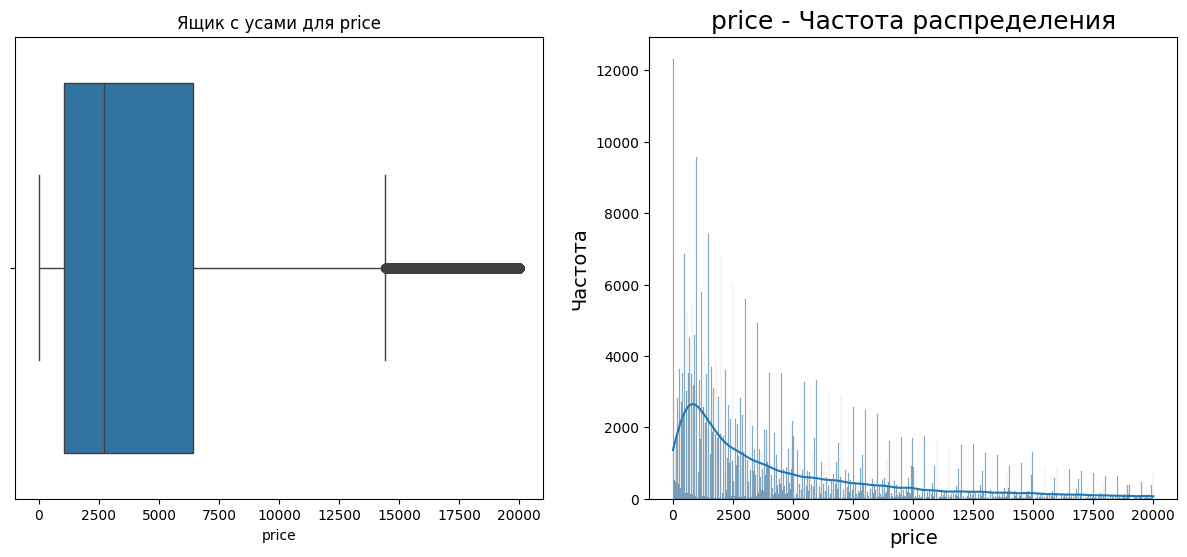

In [17]:
create_boxplot_and_histogram(df, 'price')

In [18]:
df['price'].describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

Оставим машины дороже 500 у.е., тк сомнительно, что машина может стоять 0 у.е.

In [19]:
df = df.query('price >= 500')

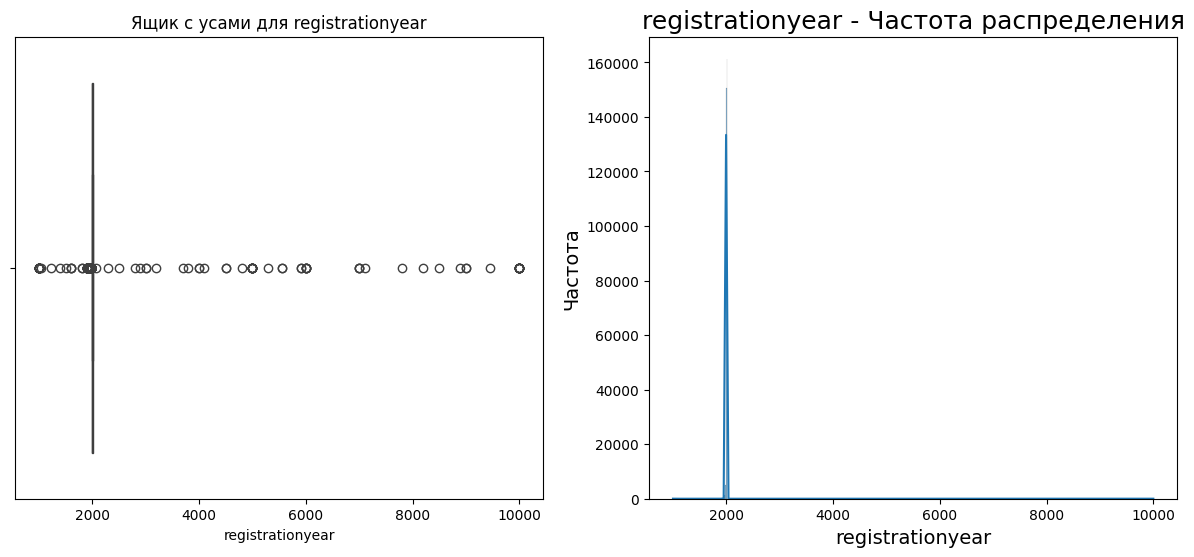

In [20]:
create_boxplot_and_histogram(df, 'registrationyear')

In [21]:
df['registrationyear'].describe()

count    318315.000000
mean       2004.164636
std          65.377755
min        1000.000000
25%        1999.000000
50%        2004.000000
75%        2008.000000
max        9999.000000
Name: registrationyear, dtype: float64

In [22]:
df = df.query('1990 <= registrationyear <= 2023')

Удалим явные аномалии и Оставим год регистрации автомобиля начиная от 1990

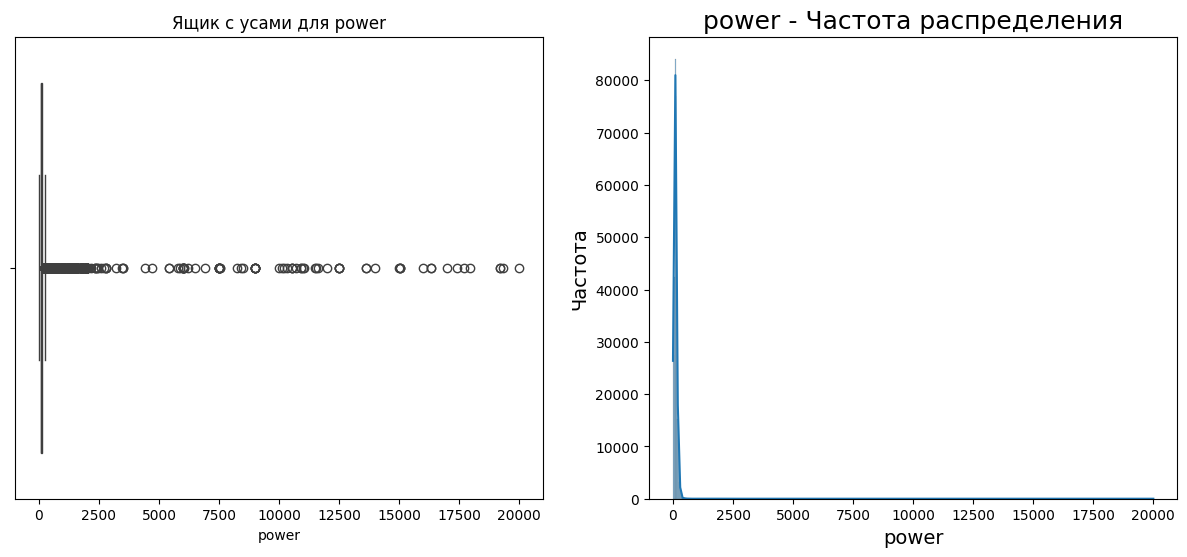

In [23]:
create_boxplot_and_histogram(df, 'power')

In [24]:
df= df.query('90< power <= 1000')

Удалим машмны с несуществующе низкими мощностями и со сверхвысокими

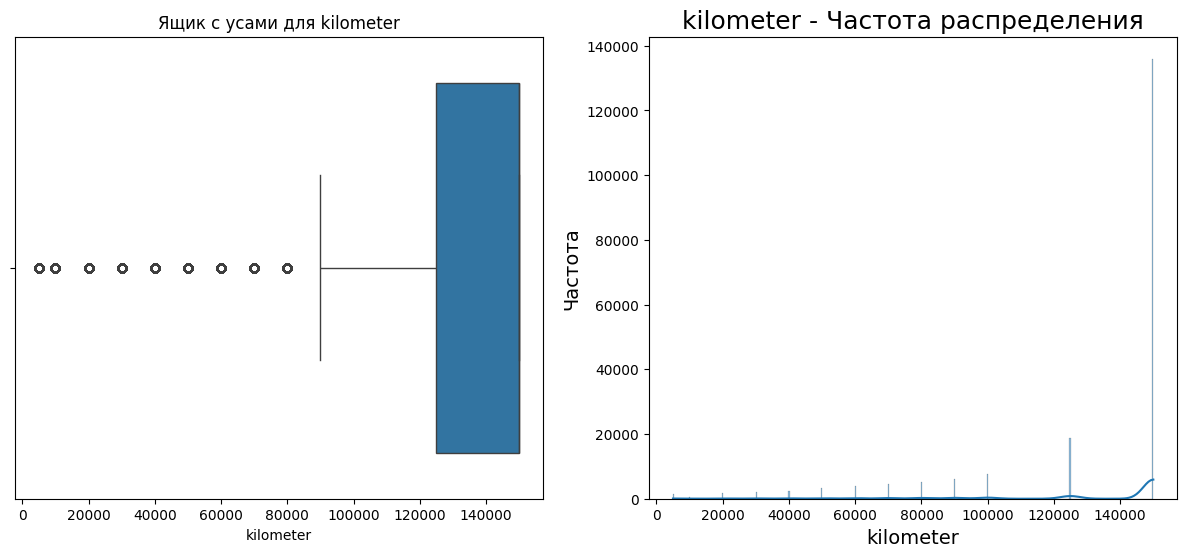

In [25]:
create_boxplot_and_histogram(df, 'kilometer')

In [26]:
df= df.query('kilometer >= 80000')

Удалим выбросы в признаке пробега

In [27]:
df.isna().sum()

price                   0
vehicletype          9905
registrationyear        0
gearbox              2246
power                   0
model                6171
kilometer               0
fueltype             9528
brand                   0
repaired            23348
dtype: int64

In [28]:
df['repaired'] = df['repaired'].fillna('no')

In [29]:
df = df.drop_duplicates().reset_index(drop=True, inplace=False)
df.duplicated().sum()

0

In [30]:
num_auto, cat_auto = cat_num_col(df)

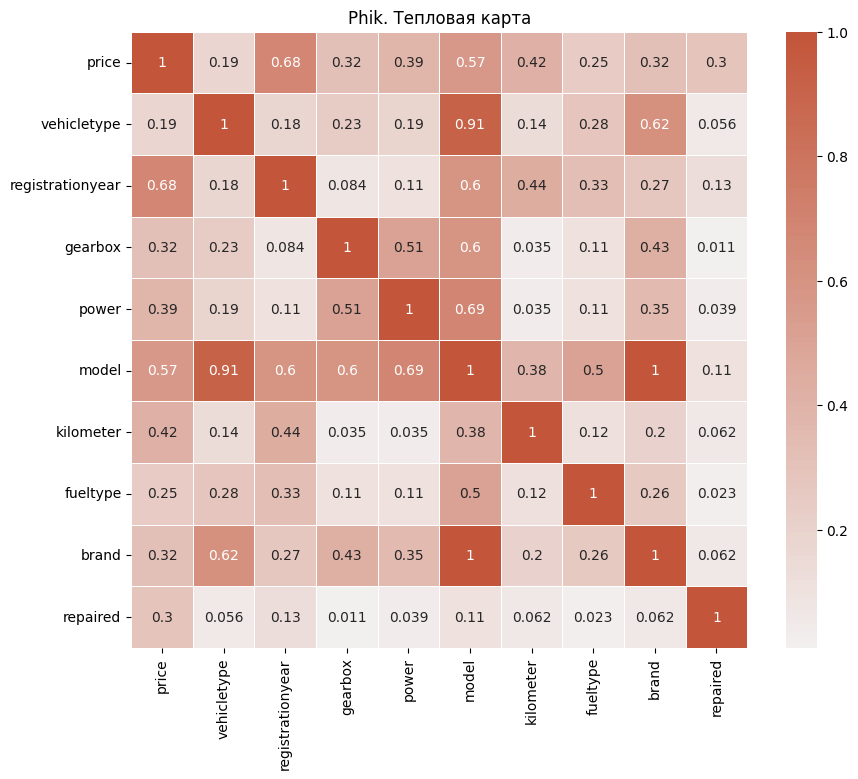

In [31]:
plot_phik_heatmap(df, num_auto)

Есть высокая зависимость между типом кузова и моделью, а также между брендом и моделью.

## Обучение моделей

In [32]:
target = df['price']
matrix = df.drop('price', axis=1)

matrix_train, matrix_test, target_train, target_test = train_test_split(
    matrix, target,
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE
)

num_matrix, cat_matrix = cat_num_col(matrix)

matrix_train[cat_matrix] = matrix_train[cat_matrix].astype('category')

matrix_test[cat_matrix] = matrix_test[cat_matrix].astype('category')
num_matrix

['registrationyear', 'power', 'kilometer']

Выполним кодировку признаков. Для категориальных будем использовать OrdinalEncoder, а для количественных StandardScaler

In [33]:
ohe_pipe = Pipeline([
    ('simpleImputer_ohe', SimpleImputer(strategy='most_frequent')),
    ('ohe', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

numeric_pipe = Pipeline(steps=[
    ('scaler', StandardScaler())
])

data_preprocessor = ColumnTransformer(transformers=[
    ('ohe', ohe_pipe, cat_matrix),
    ('num', numeric_pipe, num_matrix)
], remainder='passthrough')

Исследуем 3 модели. Возьмем дерево решений как более простую модель и 2 модели градиентного бустинга. Для исследования и выбора лучшей модели выберем метрику RMSE, а также будем смотреть на время обучения модели. Все эти данные сохраним в датафрейм для удобства

# DecisionTreeRegressor

In [34]:
pipeline_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ("decision_tree", DecisionTreeRegressor(random_state=RANDOM_STATE))
])

# Определение параметров для поиска
param_grid_tree = {
    'decision_tree__max_depth': [3, 5, 7],
    'decision_tree__min_samples_split': [2, 3, 4],
    'decision_tree__min_samples_leaf': [1, 2, 3]
}

execution_time_tree = evaluate_time(pipeline_tree, matrix_train, target_train)

best_params_tree, rmse_tree, model_tree = \
evaluate_pipeline(pipeline_tree, param_grid_tree, matrix_train, target_train)


#best_params_tree, execution_time_tree, rmse_tree, model_tree, prediction_time_tree = \
#evaluate_pipeline(pipeline_tree, param_grid_tree, matrix_train, target_train)


# CatBoostRegressor

In [35]:
pipeline_catboost = Pipeline([
    ('preprocessor', data_preprocessor),
    ("catboost", CatBoostRegressor(loss_function='RMSE', verbose=25))
])

param_grid_catboost = {
    'catboost__iterations': [100, 400]
}

execution_time_catboost = evaluate_time(pipeline_catboost, matrix_train, target_train)

best_params_catboost, rmse_catboost, model_catboost = \
evaluate_pipeline(pipeline_catboost, param_grid_catboost, matrix_train, target_train)

#best_params_catboost, execution_time_catboost, rmse_catboost, model_catboost, prediction_time_catboost = \
#evaluate_pipeline(pipeline_catboost, param_grid_catboost, matrix_train, target_train)

Learning rate set to 0.087094
0:	learn: 4269.5654013	total: 65.6ms	remaining: 1m 5s
25:	learn: 2311.4537892	total: 485ms	remaining: 18.2s
50:	learn: 2063.5965305	total: 868ms	remaining: 16.1s
75:	learn: 1980.4679467	total: 1.25s	remaining: 15.2s
100:	learn: 1930.7532453	total: 1.66s	remaining: 14.8s
125:	learn: 1898.9205033	total: 2.05s	remaining: 14.2s
150:	learn: 1874.9653104	total: 2.45s	remaining: 13.8s
175:	learn: 1854.5944168	total: 3.18s	remaining: 14.9s
200:	learn: 1837.6940198	total: 4.14s	remaining: 16.5s
225:	learn: 1822.2465181	total: 4.99s	remaining: 17.1s
250:	learn: 1809.1648139	total: 6s	remaining: 17.9s
275:	learn: 1798.7245511	total: 6.99s	remaining: 18.3s
300:	learn: 1789.0857073	total: 7.59s	remaining: 17.6s
325:	learn: 1780.5249873	total: 7.96s	remaining: 16.5s
350:	learn: 1772.3483176	total: 8.36s	remaining: 15.5s
375:	learn: 1764.8896667	total: 8.76s	remaining: 14.5s
400:	learn: 1757.2382050	total: 9.15s	remaining: 13.7s
425:	learn: 1750.5379528	total: 9.53s	rema

# LGBMRegressor

In [36]:
pipeline_lgbm = Pipeline([
    ('preprocessor', data_preprocessor),
    ("lgbm", LGBMRegressor())
])

param_grid_lgbm = {
    'lgbm__max_depth': [3, 5, 7]
}

execution_time_lgbm = evaluate_time(pipeline_lgbm, matrix_train, target_train)

best_params_lgbm, rmse_lgbm, model_lgbm  = \
evaluate_pipeline(pipeline_lgbm, param_grid_lgbm, matrix_train, target_train)

#best_params_lgbm, execution_time_lgbm, rmse_lgbm, model_lgbm, prediction_time_lgbm  = \
#evaluate_pipeline(pipeline_lgbm, param_grid_lgbm, matrix_train, target_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 118781, number of used features: 9
[LightGBM] [Info] Start training from score 5621.683300
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 558
[LightGBM] [Info] Number of data points in the train set: 118781, number of used features: 9
[LightGBM] [Info] Start training from score 

In [37]:
data = {
    "model": ['tree', 'catboost', 'lgbm'],
    "execution_time": [execution_time_tree, execution_time_catboost, execution_time_lgbm],
    "train_rmse": [rmse_tree, rmse_catboost, rmse_lgbm]
    #"prediction_time": [prediction_time_tree, prediction_time_catboost, prediction_time_lgbm]
}

df_all_model = pd.DataFrame(data)

df_all_model.head()

,model,execution_time,train_rmse
0,tree,1.680448,2330.594231
1,catboost,21.094999,1751.149808
2,lgbm,1.473024,1817.236568


## Анализ моделей

По результатам исследования все модели имеют метрику RMSE  ниже  2500. Однако лучшая модель по RMSE метрике CatBoostRegressor. Хоть она не самая быстрая по времени обучения. Посмотрим на ее гиперпараметры и выполним предсказание на тестовой выборке

In [38]:
best_params_catboost

{'catboost__iterations': 400}

In [39]:
predictions = model_catboost.predict(matrix_test)
rmse_test = mean_squared_error(target_test, predictions, squared=False)
rmse_test

1728.654895084177

# Вывод
В ходе предобработки было сделано:

* Перевели в нижний регистр названия признаков
* Удалили лишние признаки (datecrawled, datecreated, lastseen, numberofpictures, postalcode,registrationmonth)
* Удалили строки с аномальными значениями в столбцах price, registrationyear, power
* Заполнили пропуски столбце notrepaired
* Удалили 25364 дубликатов

В ходе подготовки данных к обучению было сделано:
* Преобразовали тип данных у категориальных данных
* Разделили данные на тренировочную и тестовую выборку
* Выбрали кодировщики OrdinalEncider и StandartScaler

В ходе обучения было сделано следующее:
* Для обучения выбрали 3 модели DecisionTreeRegressor, CatBoostRegressor, Light Gradient Boosting Machine
* По метрике RMSE  выбрали модель CatBoostRegressor и выполнили предсказание на тестовых данных
Модель CatBoostRegressor:

* train_rmse 1770.215567
* execution_time 43.43 сек.
* best_params iterations: 150

Значение RMSE лучшей модели на тестовой выборке - 1746